# Viacom Advertisement Optimization

### Introduction
Viacom is an American media conglomerate, founded in 2005 and headquartered in New York City. Viacom has a lot of subsidiaries, and each subsidiary has its own Facebook page. When a vendor wants to post an ad on the pages, Facebook charges Viacom CPM (Cost of Thousand Impressions) based on the demographics of ad impressions, and Viacom charges the vendor a CPM around 25 dollars.

### Project Motivation
- Build a model to predict CPM charged by Facebook, in order to improve Viacom's pricing strategies towards the ad vendors
- Analyze the page metrics data to gain insights regarding page metrics (impressions, CTR, funnels)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
%config InlineBackend.figure_formats = ['retina']
plt.style.use('seaborn-dark')


### Data
The input data: (because of the confidentiality agreement with Viacom, source data is not uploaded to Github)

- cpm.csv - CPM data for 16 months starting 01/2018
- page_metrics.csv - page metrics data including page impressions, page views, and ad clicks during the same time period
- page_demo.csv - page impressions data collected by demographics

In [2]:
# Import the CPM data
cpm = pd.read_csv('clean_data/cpm.csv', parse_dates=['date'])
print(f'From {min(cpm.date)} to {max(cpm.date)}')
print(cpm.shape)
cpm.head()

From 2018-04-13 00:00:00 to 2019-02-21 00:00:00
(91646, 13)


,age_min,age_max,female,male,cpm,hID,date,age_group,gender,demographic,year,month,day
0,18,24,0,1,3.678763,8910733059390721166,2018-10-02,18-24,male,18-24 male,2018,10,2
1,18,24,1,0,3.026950,8910733059390721166,2018-10-02,18-24,female,18-24 female,2018,10,2
2,18,24,1,1,3.114728,8910733059390721166,2018-10-02,18-24,unisex,18-24 unisex,2018,10,2
3,25,34,0,1,3.011565,8910733059390721166,2018-10-02,25-34,male,25-34 male,2018,10,2
4,25,34,1,0,4.032152,8910733059390721166,2018-10-02,25-34,female,25-34 female,2018,10,2


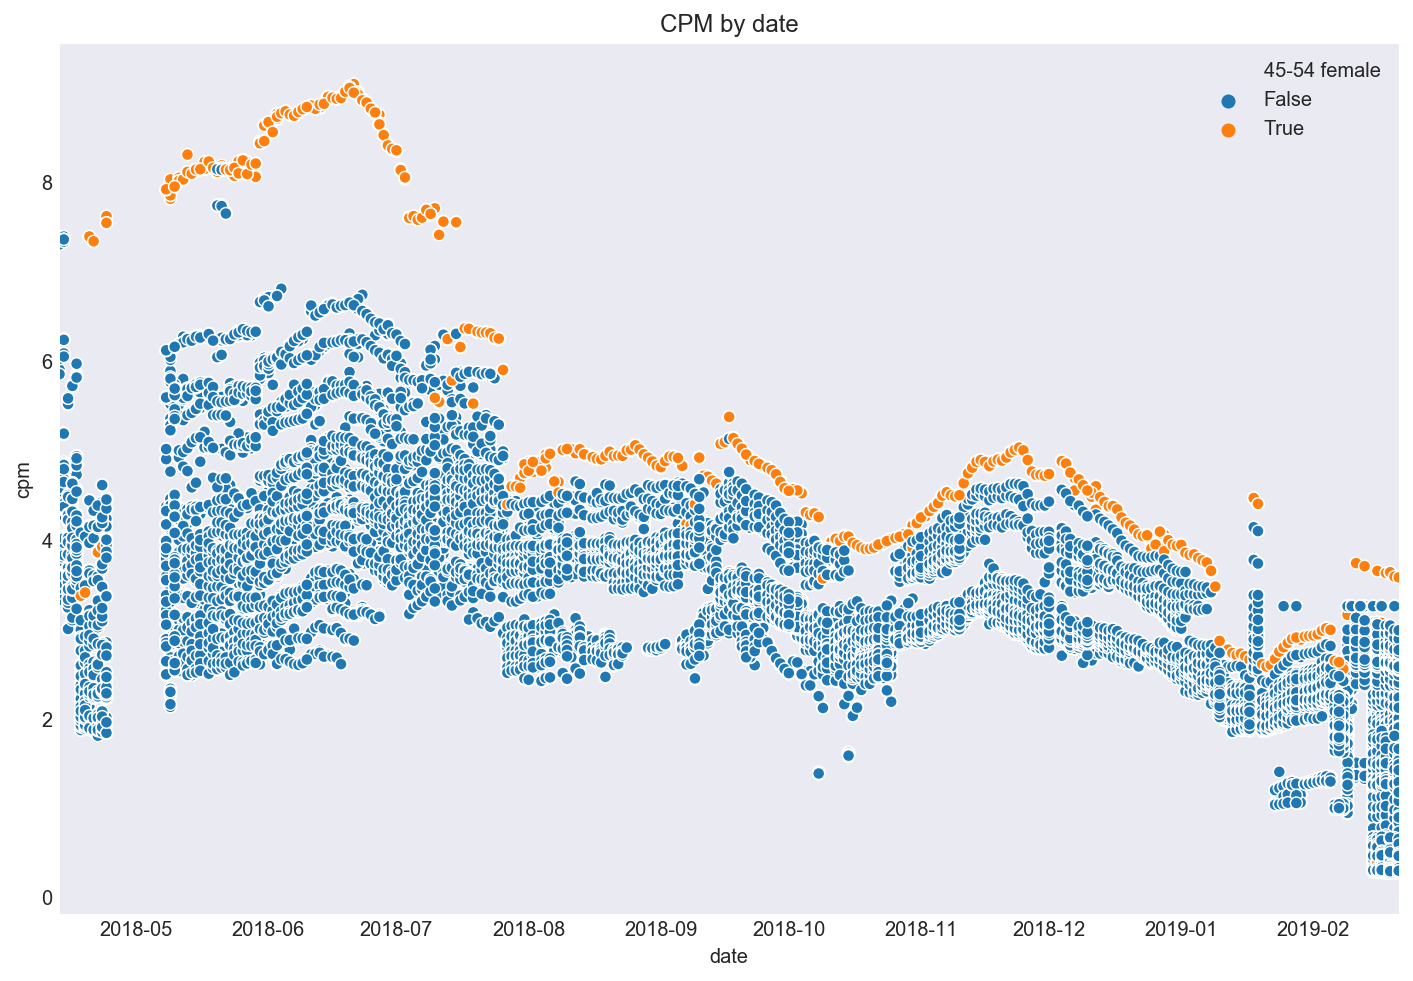

In [4]:
# High light the outlier demographic in the scatter plot
cpm['45-54 female'] = cpm.demographic == '45-54 female'

# Plot scatter plot
plt.figure(figsize=(12,8))
sns.scatterplot(data=cpm, x='date', y='cpm', hue='45-54 female')
plt.xlim(min(cpm['date']), max(cpm['date']))
plt.title('CPM by date')
plt.show()

# Remove the temporary feature from cpm data
cpm.drop('45-54 female',axis=1,inplace=True)

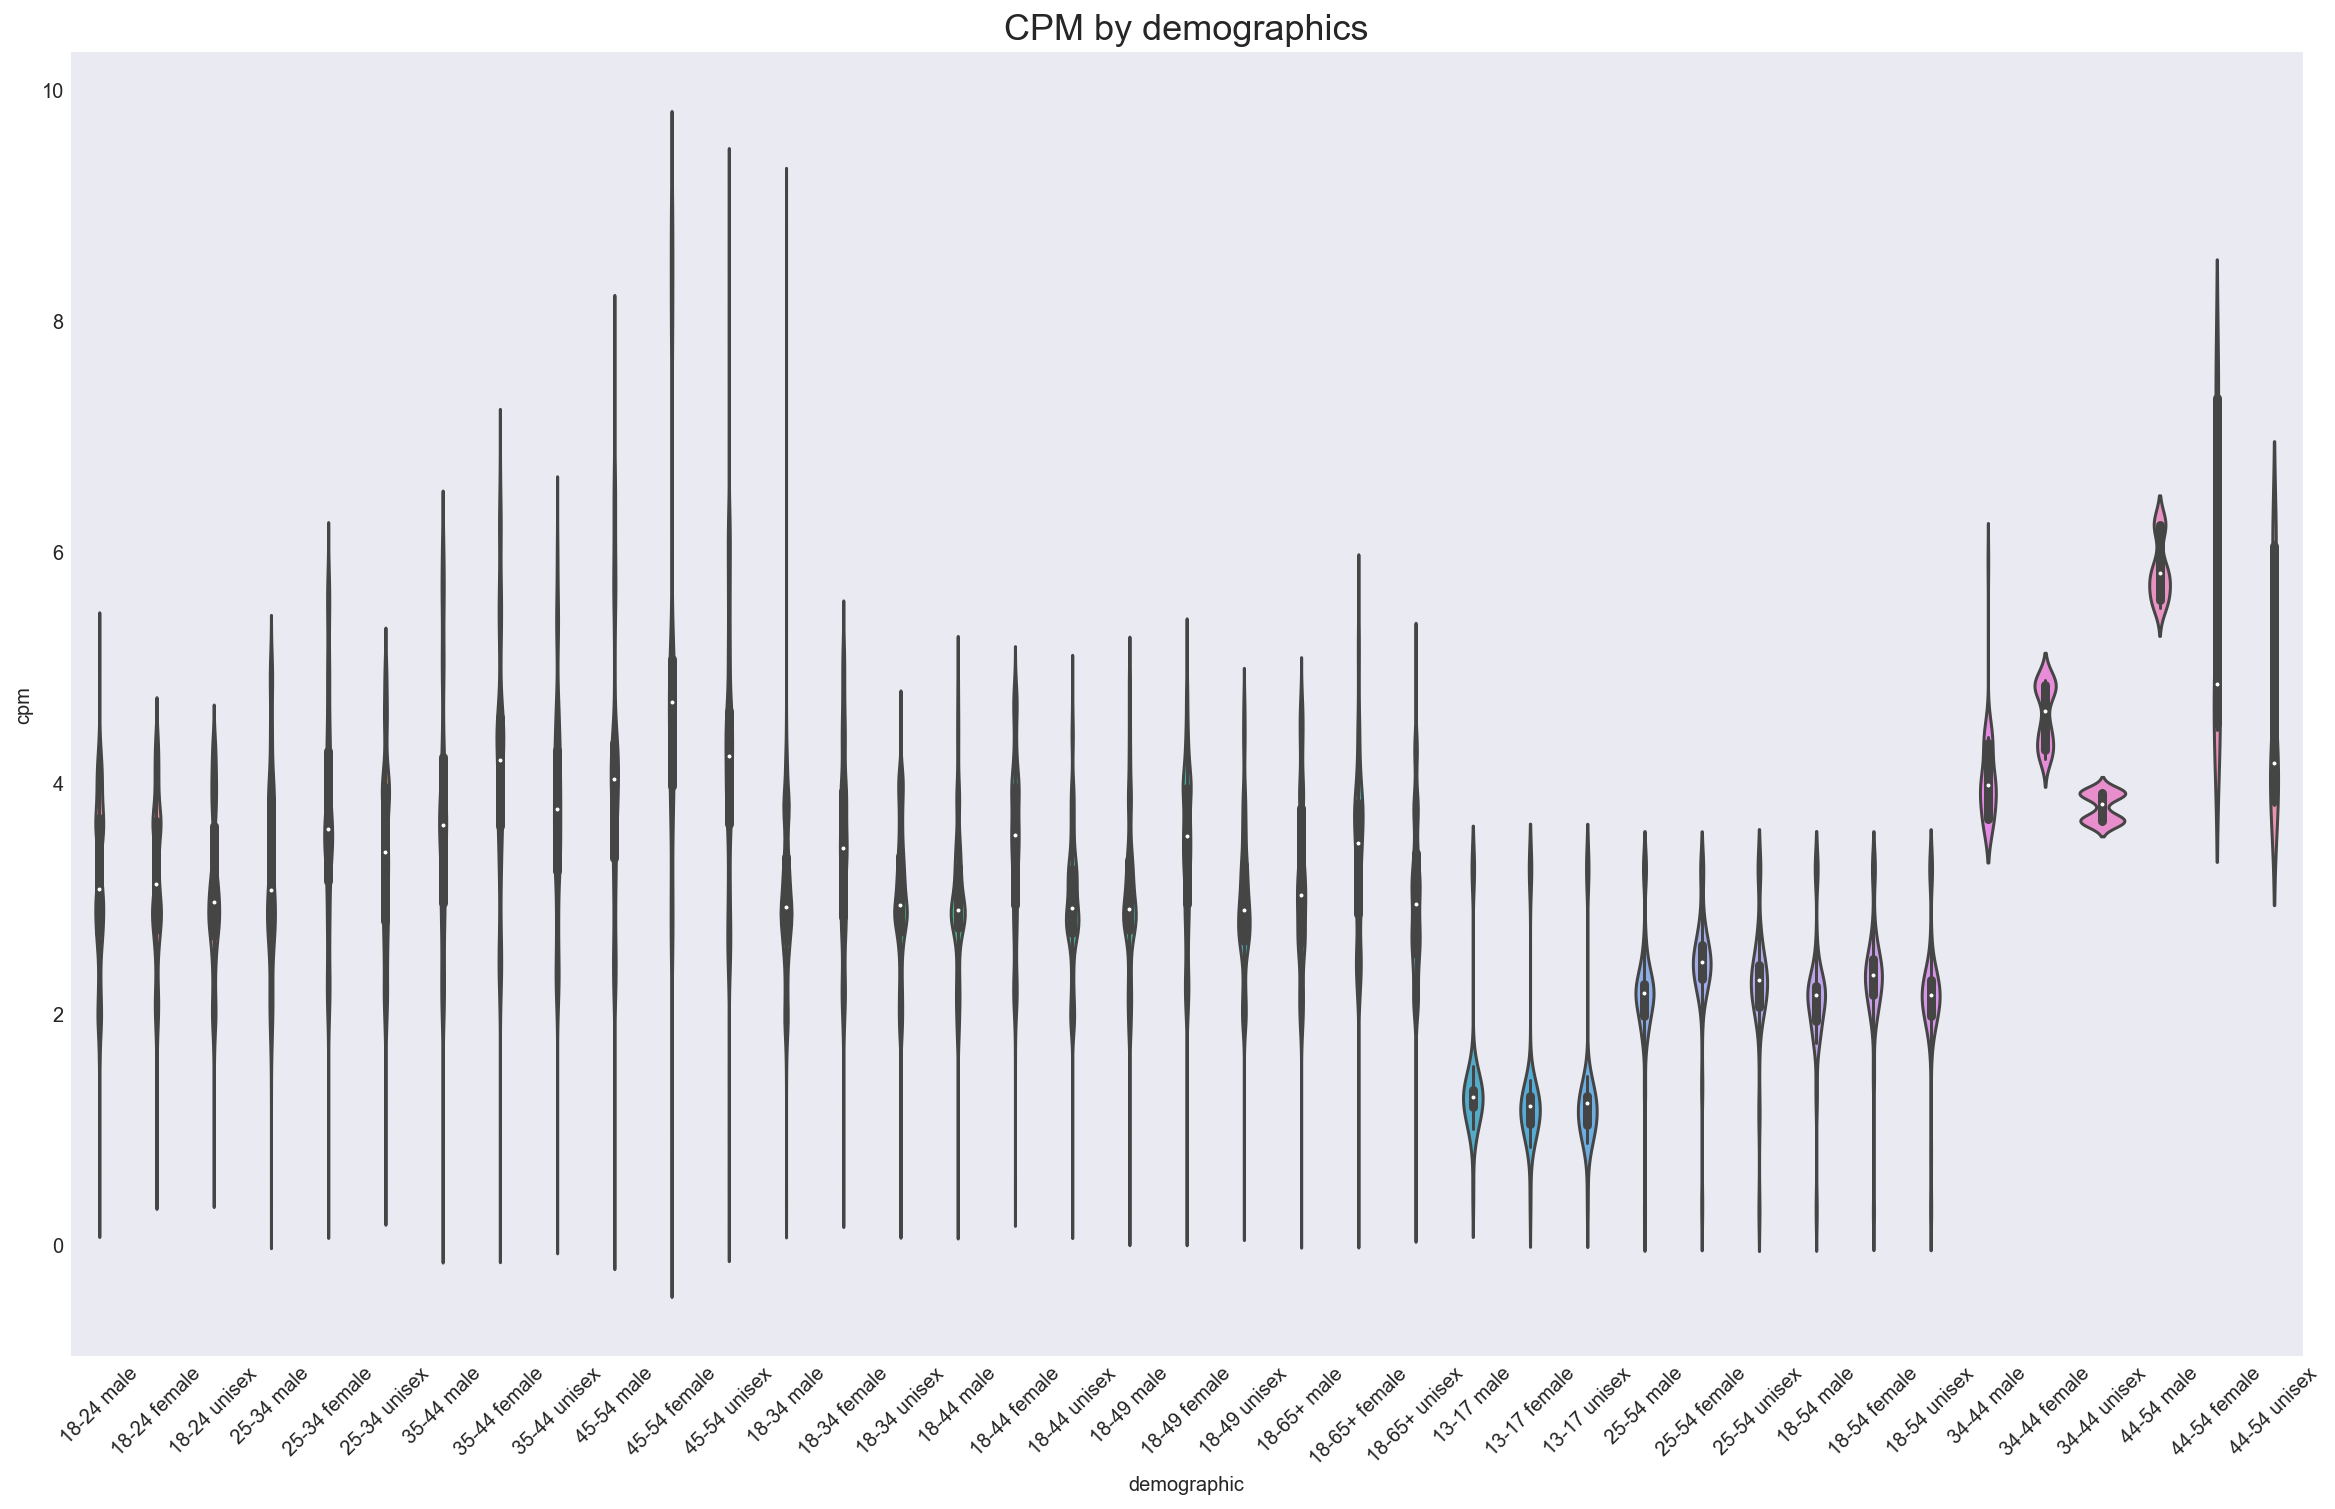

In [5]:
# Plot CPM by demographics
plt.figure(figsize=(20,12))
sns.violinplot(data=cpm, x='demographic', y='cpm')
plt.title('CPM by demographics',size=18)
plt.xticks(rotation=45)
plt.show()

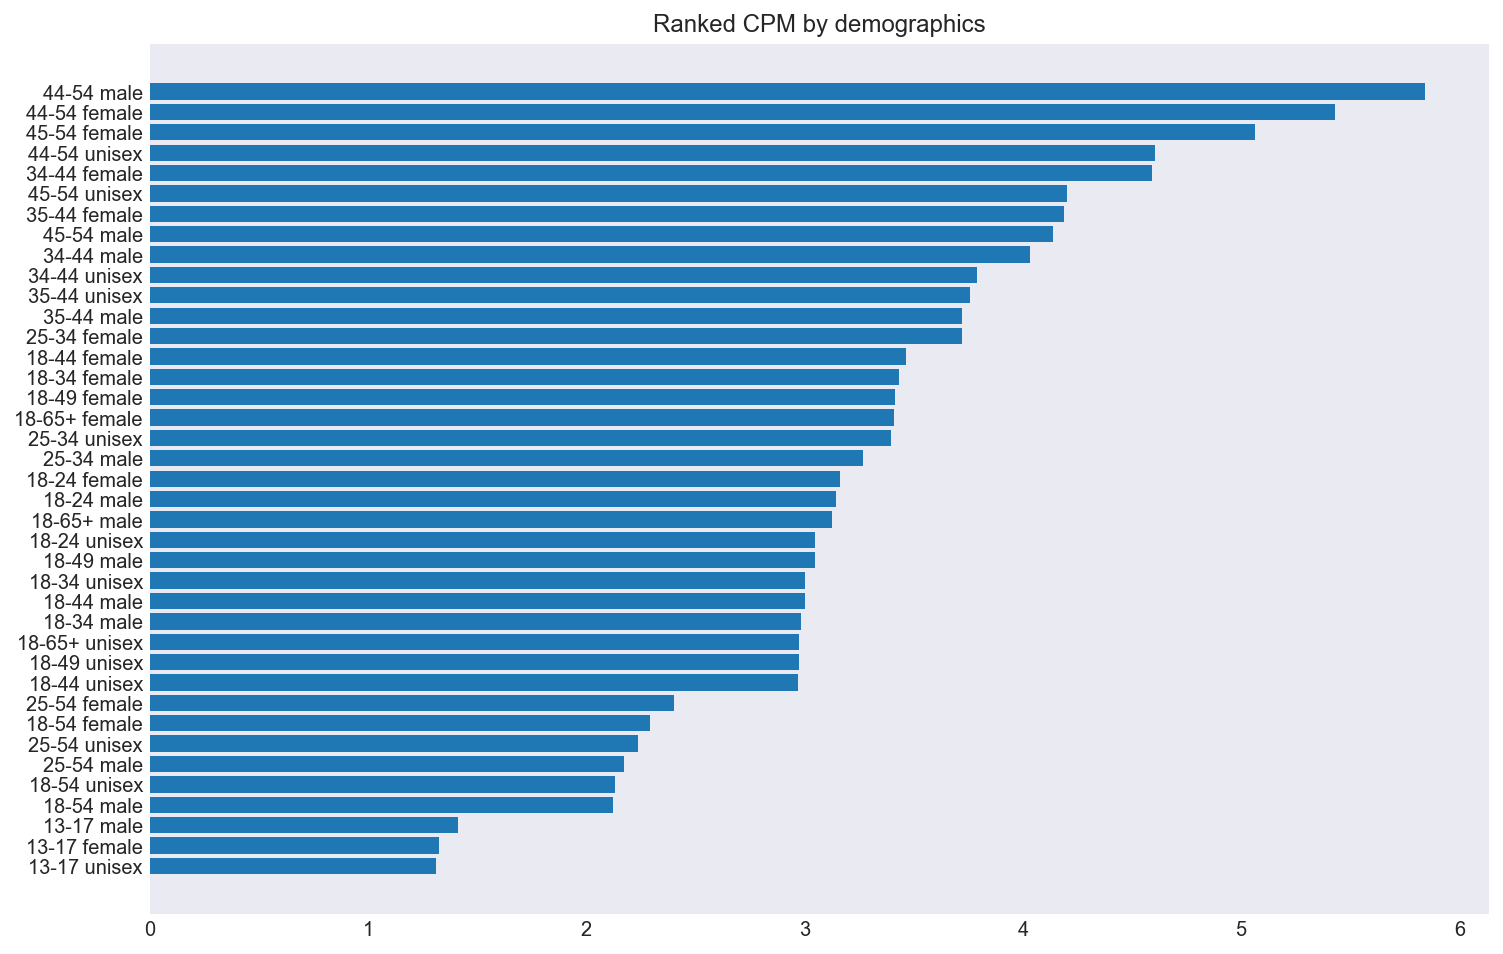

In [6]:
# Create a dataframe for ranked demographic by average cpm
avg_demo_cpm = cpm.groupby('demographic').cpm.mean().sort_values().to_frame()

# Plot bar chart
plt.figure(figsize=(12,8))
plt.barh(avg_demo_cpm.index, avg_demo_cpm['cpm'])
plt.title('Ranked CPM by demographics')
plt.show()

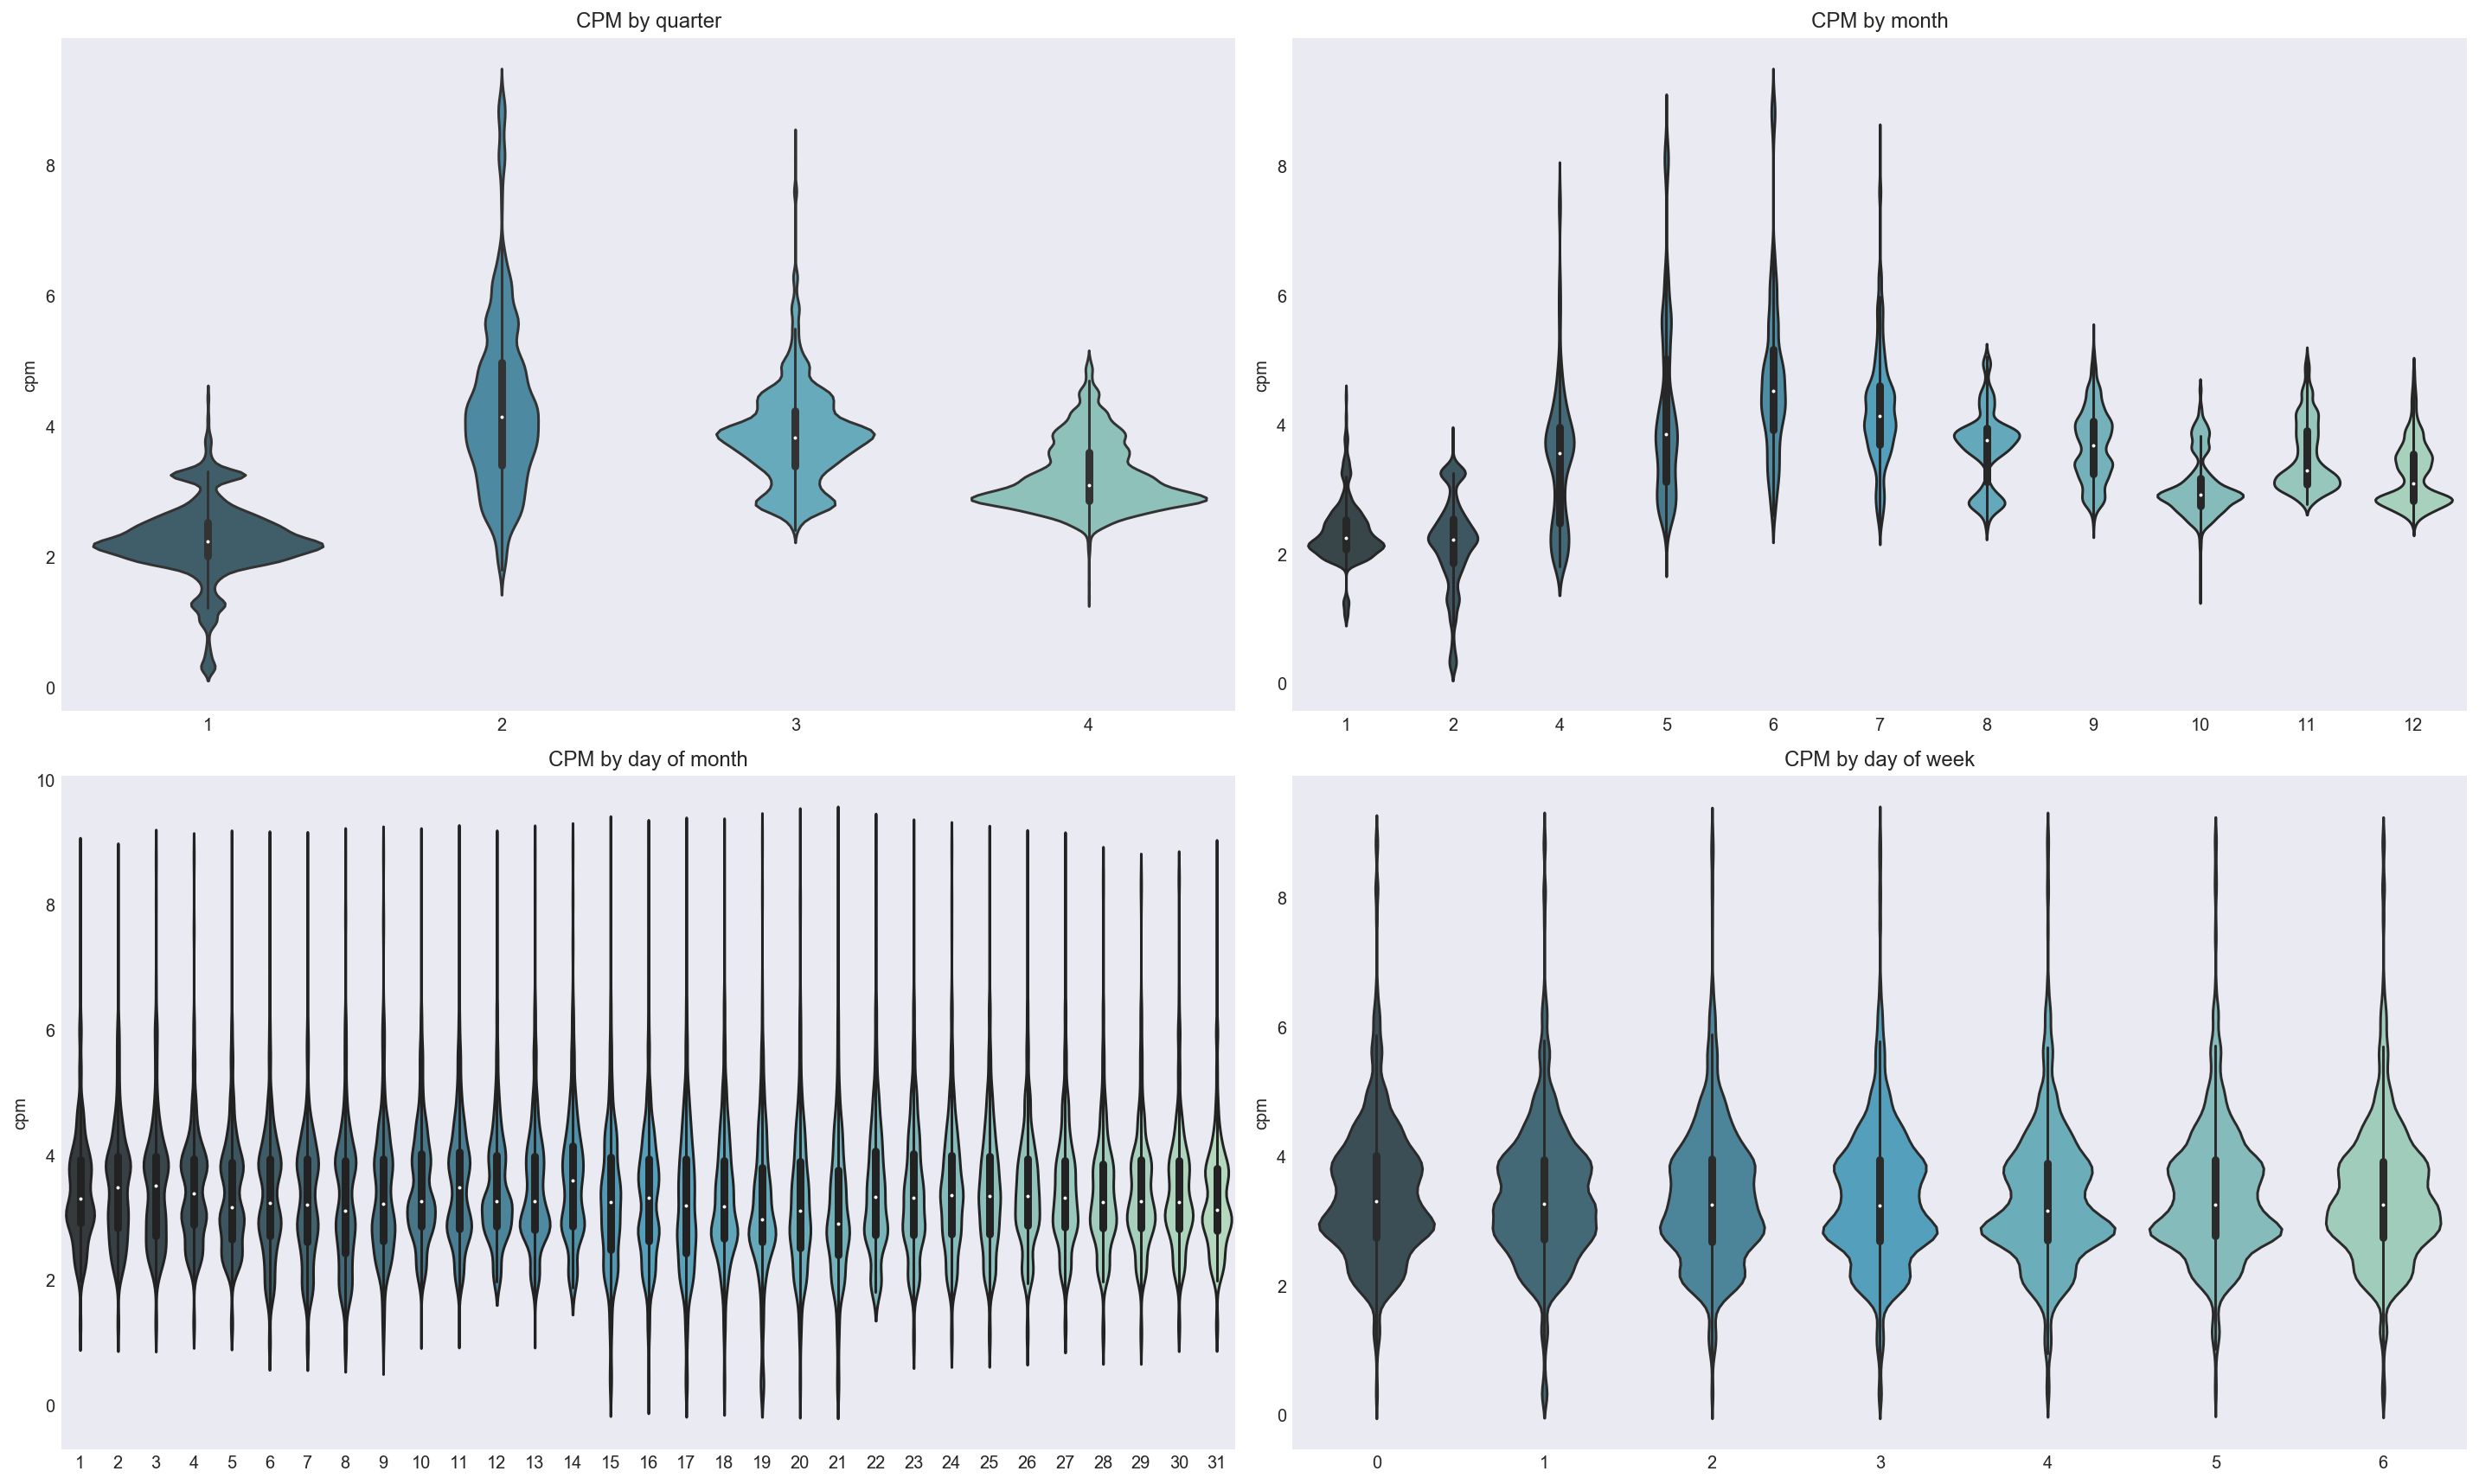

In [11]:
# add additional features
cpm['quarter'] = cpm.date.dt.quarter
cpm['dayofweek'] = cpm.date.dt.dayofweek

# Plot CPM by different time granularities
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
sns.violinplot(data=cpm, x='quarter', y='cpm', palette='GnBu_d')
plt.title('CPM by quarter'); plt.xlabel('')
plt.subplot(2,2,2)
sns.violinplot(data=cpm, x='month', y='cpm', palette='GnBu_d')
plt.title('CPM by month'); plt.xlabel('')
plt.subplot(2,2,3)
sns.violinplot(data=cpm, x='day', y='cpm', palette='GnBu_d')
plt.title('CPM by day of month'); plt.xlabel('')
plt.subplot(2,2,4)
sns.violinplot(data=cpm, x='dayofweek', y='cpm', palette='GnBu_d')
plt.title('CPM by day of week'); plt.xlabel('')
plt.tight_layout()
plt.show()

# Drop temporary features
cpm.drop(['quarter','dayofweek'],axis=1,inplace=True)

### Build a Random Forest Regression Model
- The R-squared scores are almost all above 0.95, which means we have a highly reliable model for predicting CPM charged by Facebook

In [12]:
# Create list of features to be used
features_cpm = ['age_min','age_max','female','male','year','month','day']

# Create a Random Forest model on the whole data
X = cpm[features_cpm]
y = cpm.cpm
model = RandomForestRegressor()

# Run cross validations
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print('The cross validation R-squared results are:', scores)

# Train model on all CPM data
model.fit(X, y)

The cross validation R-squared results are: [0.99320949 0.98694107 0.99033387 0.97054508 0.9073267 ]


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### Import page impressions by demographics data

In [14]:
page_demo = pd.read_csv('clean_data/page_demo.csv',parse_dates=['date'])
print(page_demo.shape)
print(f'From {min(page_demo.date)} to {max(page_demo.date)}')

# Predict cpm on page_demo data
page_demo['cpm'] = model.predict(page_demo[features_cpm])
page_demo.head()

(2094349, 12)
From 2018-01-01 00:00:00 to 2019-04-08 00:00:00


,date,metric,impressions,hID,age_group,age_min,age_max,female,male,year,month,day,cpm
0,2019-01-01,U.35-44,4.0,3141727685331597704,35-44,35,44,1,1,2019,1,1,3.305084
1,2019-01-02,M.25-34,242.0,3141727685331597704,25-34,25,34,0,1,2019,1,2,2.511695
2,2019-01-06,F.55-64,67.0,3141727685331597704,55-64,55,64,1,0,2019,1,6,3.767985
3,2019-01-01,F.55-64,133.0,3141727685331597704,55-64,55,64,1,0,2019,1,1,3.943439
4,2019-01-03,M.45-54,86.0,3141727685331597704,45-54,45,54,0,1,2019,1,3,3.229934


In [15]:
demo_pivot = pd.pivot_table(page_demo,index='hID',columns='metric',values='impressions')
demo_pivot.fillna(0,inplace=True)
demo_pivot.head()

metric,F.13-17,F.18-24,F.25-34,F.35-44,F.45-54,F.55-64,F.65+,M.13-17,M.18-24,M.25-34,...,M.45-54,M.55-64,M.65+,U.13-17,U.18-24,U.25-34,U.35-44,U.45-54,U.55-64,U.65+
hID,,,,,,,,,,,,,,,,,,,,,
-9185217652402180575,1.000000,14.250000,7.000000,3.750000,1.666667,0.000000,1.333333,1.000000,21.500000,16.250000,...,1.750000,1.666667,1.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-9175544061209790002,1488.161987,7324.786177,2033.017279,649.401728,411.315335,156.842333,100.786177,1174.552916,7539.801296,3473.632829,...,242.082073,87.215983,87.131749,4.904645,17.339093,26.556277,13.290993,5.632517,3.158333,2.660944
-9156617651427282577,178.563715,8906.926566,9127.308855,2966.069114,978.872570,364.768398,233.019608,432.537797,27721.300216,31914.917927,...,2425.267819,680.536957,567.385621,2.785714,69.477833,148.692483,70.917476,23.927807,11.366242,10.148026
-9145254332915205176,287.978469,9426.169935,9863.588235,4900.424837,2547.244009,910.905495,421.085903,32.628169,1213.041394,2478.958606,...,1518.024070,536.234513,248.752941,1.762821,22.217082,84.093373,72.188235,41.828125,16.821306,8.942029
-9124186022016029939,542.125270,1877.827214,748.198704,347.563715,221.708423,89.684665,57.082073,120.565875,752.272138,469.704104,...,149.647948,48.615551,25.837662,1.172414,1.990066,2.277397,2.994975,1.389610,1.240000,1.099688


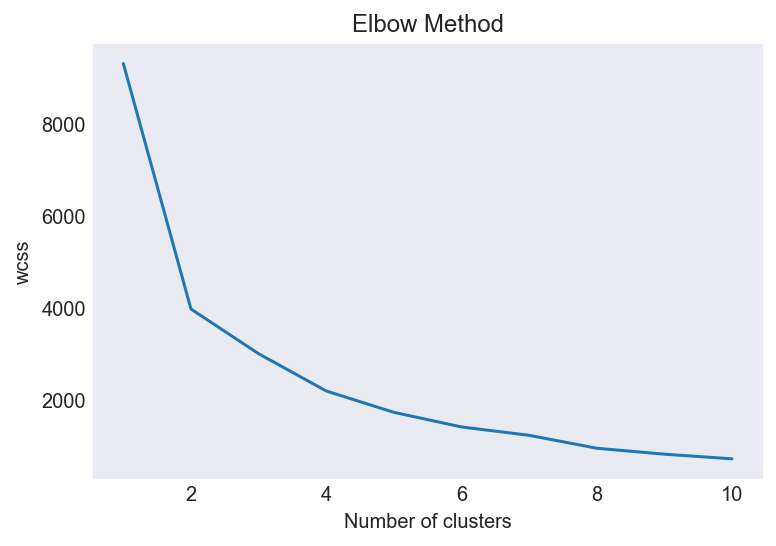

In [17]:
# Scale X
scaler = StandardScaler()
X = scaler.fit_transform(demo_pivot)

# Use the elbow method
wcss = []
for i in range(1,11):
    km = KMeans(n_clusters=i)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [19]:
# K-means clustering on demo_pivot data
kmeans = KMeans(n_clusters=4, random_state=42)
y_means = kmeans.fit_predict(X)
demo_pivot['cluster'] = y_means

# Calculate the average impressions by cluster by demographic
cluster0 = demo_pivot[demo_pivot.cluster == 0].mean()
cluster1 = demo_pivot[demo_pivot.cluster == 1].mean()
cluster2 = demo_pivot[demo_pivot.cluster == 2].mean()
cluster3 = demo_pivot[demo_pivot.cluster == 3].mean()
cluster_demo = pd.concat([cluster0, cluster1, cluster2, cluster3],axis=1)
cluster_demo.columns = ['cluster0','cluster1','cluster2','cluster3']

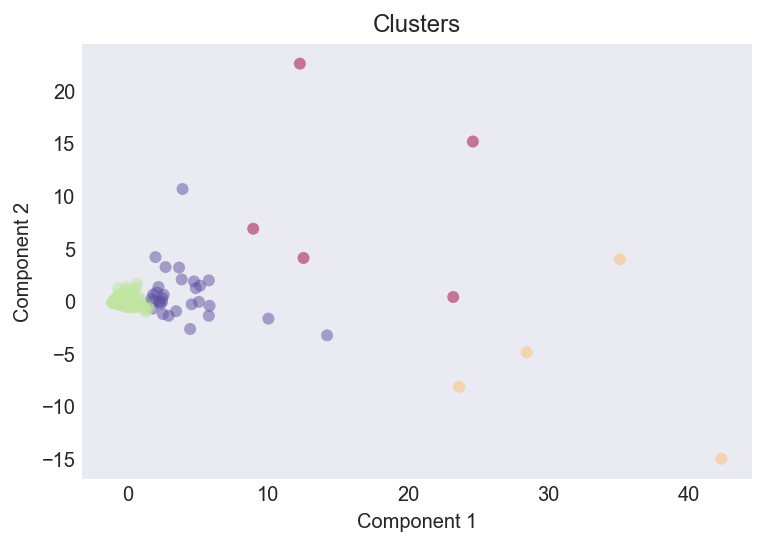

In [22]:
# Apply PCA and fit the features selected
pca = PCA(n_components=2).fit(X)

# Transform samples using the PCA fit
pca_2d = pca.transform(X)

# fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1],
            c=y_means, 
            edgecolor="none",
            cmap=plt.cm.get_cmap("Spectral_r", 4),
            alpha=0.5)

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Clusters')
plt.show()

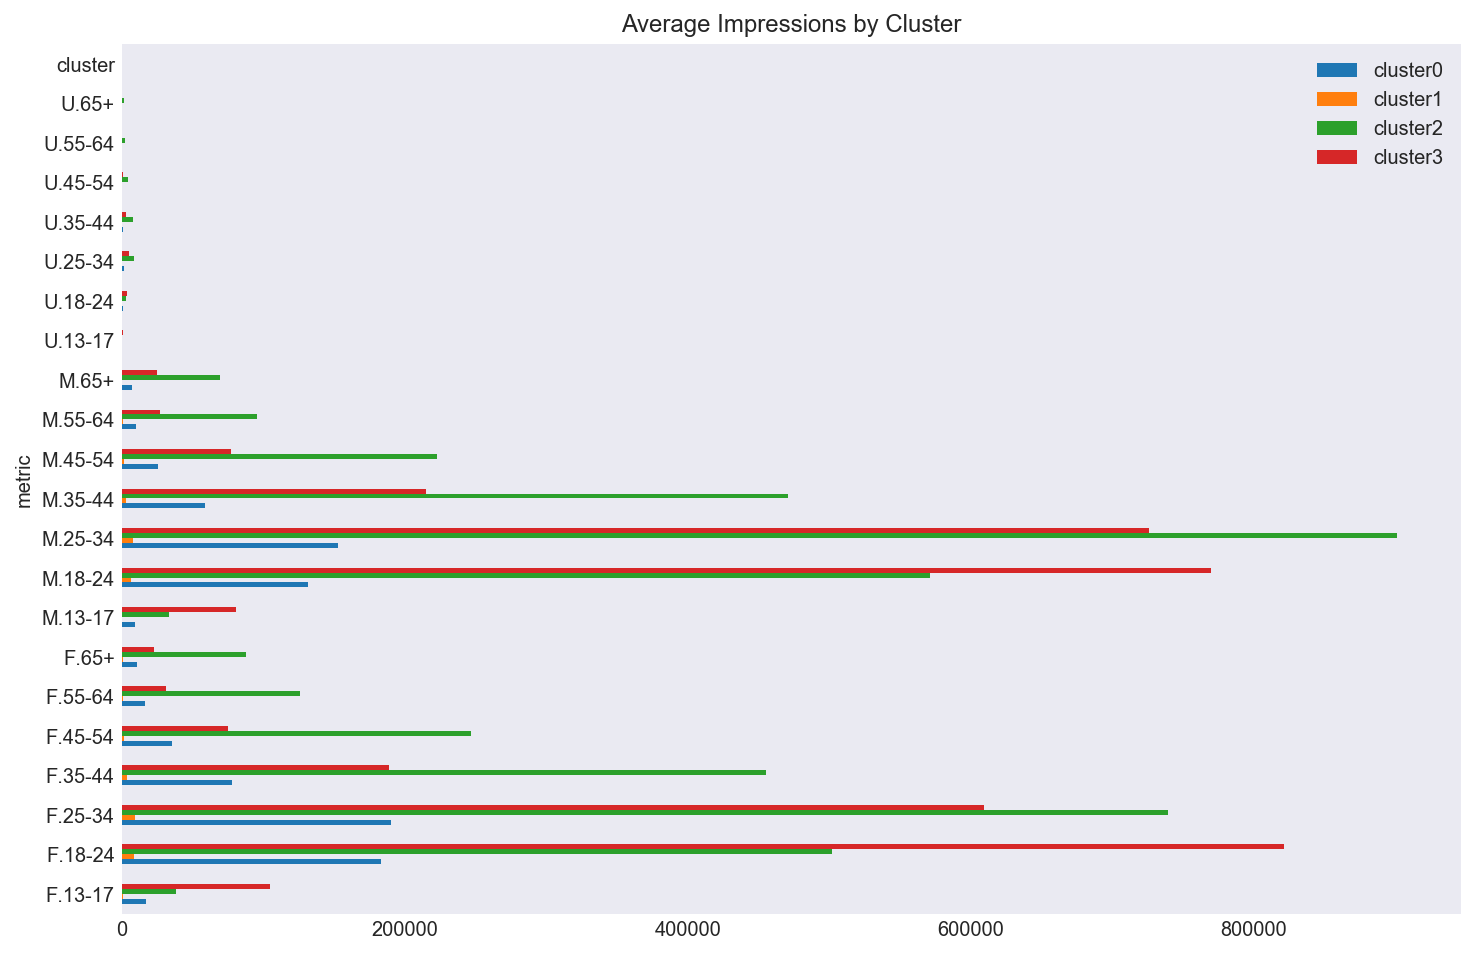

In [20]:
cluster_demo.plot(kind='barh',figsize=(12,8))
plt.title('Average Impressions by Cluster')
plt.show()

In [4]:
page_metrics = pd.read_csv('clean_data/page_metrics.csv', parse_dates=['date'])
print(page_metrics.shape)
print(f'From {min(page_metrics.date)} to {max(page_metrics.date)}')
page_metrics.head()

(23571232, 5)
From 2018-01-01 00:00:00 to 2019-04-09 00:00:00


,date,name,metric,value,hID
0,2019-01-03,page_fans_online,15,5276.0,-4906017303833771552
1,2019-01-05,page_fans_online,2,4191.0,-4906017303833771552
2,2019-01-05,page_views,value,5.0,-4906017303833771552
3,2019-01-01,page_fans_online,7,5996.0,-4906017303833771552
4,2019-01-02,page_fans_online,18,4929.0,-4906017303833771552


In [5]:
page_metrics.name.unique()

array(['page_fans_online', 'page_views', 'page_impressions_organic',
       'page_video_views_paid', 'page_post_engagements',
       'page_impressions_paid', 'page_posts_impressions_paid',
       'page_cta_clicks_logged_in_total', 'page_impressions',
       'page_posts_impressions_organic', 'page_video_views',
       'page_posts_impressions', 'page_views_total',
       'page_video_views_organic', 'page_impressions_by_city_unique',
       'page_impressions_by_locale_unique',
       'page_impressions_by_country_unique',
       'page_impressions_by_age_gender_unique',
       'page_views_by_age_gender_logged_in_unique'], dtype=object)

In [6]:
# Prepare pivot table for clustering
page_metrics = page_metrics.pivot_table(index=['hID'],columns='name',values='value')
page_metrics.fillna(0,inplace=True)
page_metrics['click_through_rate'] = page_metrics.page_cta_clicks_logged_in_total / page_metrics.page_impressions
page_metrics.head()

name,page_cta_clicks_logged_in_total,page_fans_online,page_impressions,page_impressions_by_age_gender_unique,page_impressions_by_city_unique,page_impressions_by_country_unique,page_impressions_by_locale_unique,page_impressions_organic,page_impressions_paid,page_post_engagements,page_posts_impressions,page_posts_impressions_organic,page_posts_impressions_paid,page_video_views,page_video_views_organic,page_video_views_paid,page_views,page_views_by_age_gender_logged_in_unique,page_views_total,click_through_rate
hID,,,,,,,,,,,,,,,,,,,,
-9185217652402180575,0.004310,4.418708e+03,3.734914,6.911111,1.160377,2.704348,5.271186,2.765086,0.000000,0.157143,2.573276,2.545259,0.000000,0.047414,0.047414,0.000000,2.140086,0.002407,3.797414,0.001154
-9175544061209790002,0.102371,3.015649e+04,42227.849138,1267.858142,248.733813,533.320662,587.465573,39002.258621,519.211207,1968.267857,42094.795259,38935.765086,519.211207,10874.331897,10675.101293,199.230603,67.974138,0.616838,104.209052,0.000002
-9156617651427282577,0.000000,1.511784e+06,138128.620690,4962.838895,299.510414,2223.923943,2596.407059,136404.836207,0.000000,17550.317857,132958.556034,131350.823276,0.000000,47306.379310,47306.377155,0.000000,217.008621,18.267186,309.898707,0.000000
-9145254332915205176,1.365302,5.988992e+04,61178.931034,2031.175462,177.254221,1105.628040,1264.154201,41571.163793,19439.112069,15475.959459,60281.762931,40821.657328,19439.112069,34830.293103,32449.193966,2381.099138,797.609914,38.713068,842.922414,0.000022
-9124186022016029939,0.050647,9.573942e+04,14145.385776,326.511296,40.135500,126.031391,157.373803,13762.400862,0.000000,490.339286,14017.420259,13667.103448,0.000000,245.525862,245.525862,0.000000,32.926724,0.114706,43.133621,0.000004


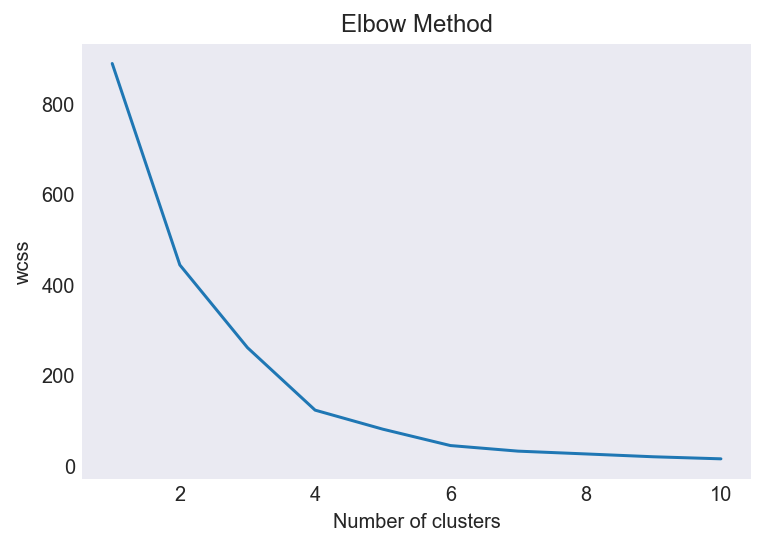

In [26]:
page_impressions = page_metrics[['page_impressions','page_cta_clicks_logged_in_total']].copy()

# Scale X
scaler = StandardScaler()
X = scaler.fit_transform(page_impressions)

# Use the elbow method
wcss = []
for i in range(1,11):
    km = KMeans(n_clusters=i)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

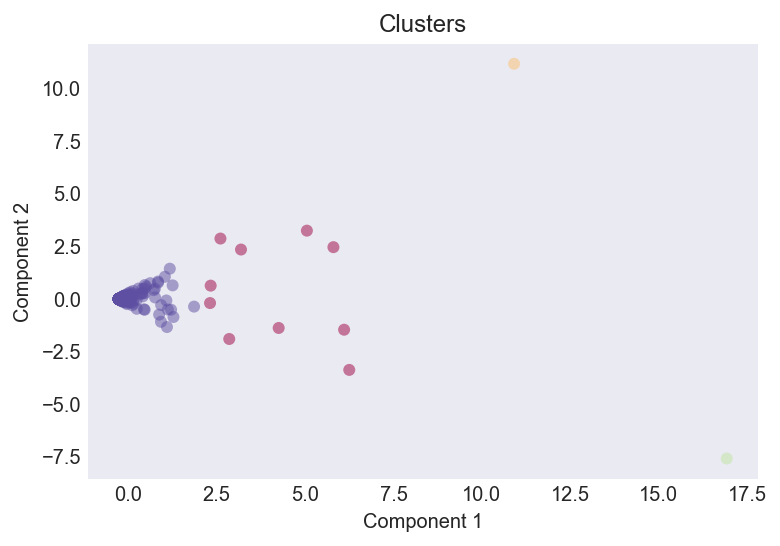

In [27]:
# Fit K-means
kmeans = KMeans(n_clusters=4, random_state=42)
y_means = kmeans.fit_predict(X)
page_impressions['cluster'] = y_means

# Apply PCA and fit the features selected
pca = PCA(n_components=2).fit(X)

# Transform samples using the PCA fit
pca_2d = pca.transform(X)

# fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(pca_2d[:, 0], pca_2d[:, 1],
            c=y_means, 
            edgecolor="none",
            cmap=plt.cm.get_cmap("Spectral_r", 4),
            alpha=0.5)

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('Clusters')
plt.show()

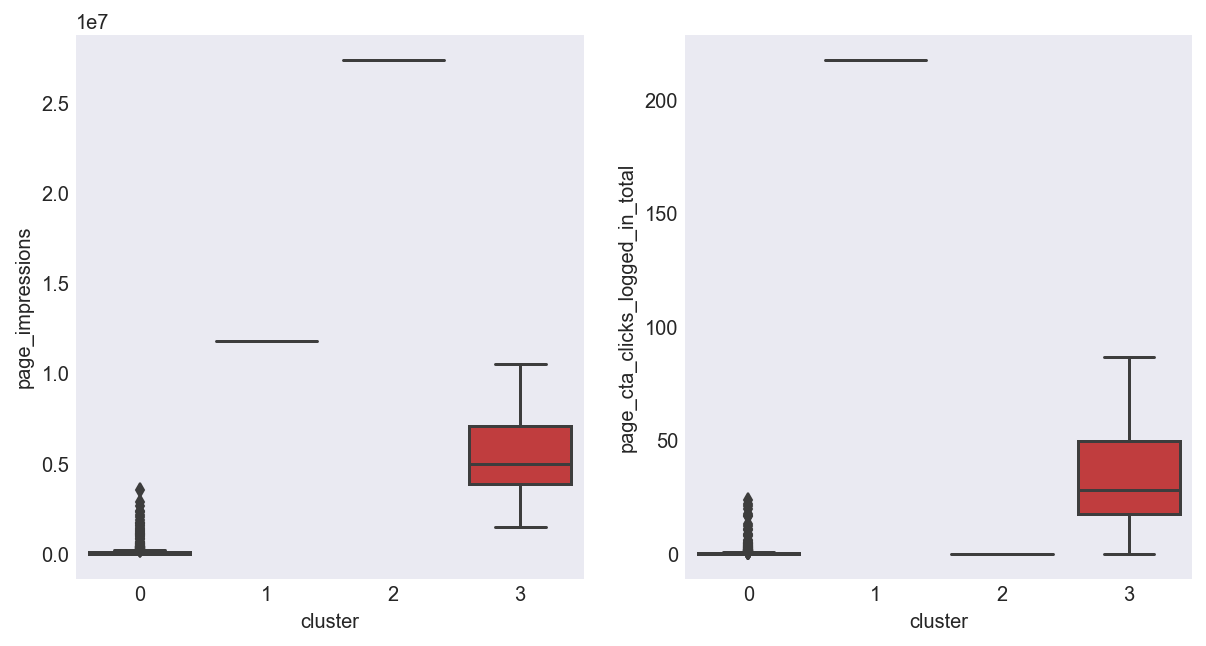

In [37]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(data=page_impressions, x='cluster', y='page_impressions')
plt.subplot(1,2,2)
sns.boxplot(data=page_impressions, x='cluster', y='page_cta_clicks_logged_in_total')
plt.show()